# Lecture 19: Matrix functions and matrix equations

## Previous lecture

- Large scale eigenvalue problem
- Krylov subspace based methods
- Preconditioned inverse iteration
- LOBPCG
- Jacobi-Davidson method

## Today lecture

- Matrix function
- Matrix exponential and rational Krylov subspaces
- Randomized numerical linear algebra

## Outline of this part

- What is a matrix function
- Matrix exponential
- (Some) applications

Book to read: [Functions of matrices by Nick Higham](http://www.google.ru/books?hl=ru&lr=&id=2Wz_zVUEwPkC&oi=fnd&pg=PR3&dq=Higham+matrix+function&ots=pTt6fpLGRX&sig=DgUuX-SpBZGin8CFUo-4MYnOcHE&redir_esc=y#v=onepage&q=Higham%20matrix%20function&f=false)

## The simplest matrix function: matrix polynomial

It is very easy to define a matrix polynomial as  

$$ P(A) = \sum_{k=0}^n c_k A^k. $$

**Side-note:** [Hamilton-Cayley theorem](https://en.wikipedia.org/wiki/Cayley%E2%80%93Hamilton_theorem) states that $F(A) = 0$ where $F(\lambda) = \det(A - \lambda I)$, thus all matrix polynomials have degree $\leq n-1$.

## Matrix polynomials as building blocks
We can define a function of the matrix by **Taylor series**:  

$$ f(A) = \sum_{k=0}^{\infty} c_k A^k. $$

The convergence is understood as the convergence in some **matrix norm**.  

Example of such series is the **Neumann series**  

$$ (I - F)^{-1} = \sum_{k=0}^{\infty} F^k, $$

which is well defined for $\rho(F) < 1$.

## Matrix exponential series
The most well-known matrix function is **matrix exponential**. In the scalar case,  

$$ e^x = 1 + x + \frac{x^2}{2} + \frac{x^3}{6} + \ldots = \sum_{k=0}^{\infty} \frac{x^k}{k!}, $$

and it directly translates to the matrix case:  

$$ e^A = \sum_{k=0}^{\infty} \frac{A^k}{k!}, $$

the series that always converges, because the series

$$\sum_{k=0}^{\infty} \frac{\Vert A \Vert^k}{k!} = e^{\Vert A \Vert}.$$

## Why matrix exponential is important

A **lot of** practical problems are reduced to a system of linear ODEs of the form  

$$ \frac{dy}{dt} = Ay, \quad y(0) = y_0. $$


## ODE and matrix exponentials

- Given the equation 

$$\frac{dy}{dt} = Ay, \quad y(0) = y_0$$

- The formal solution is given by $y(t) = e^{At} y_0$, so if we know  $e^{At}$ (or can compute matrix-by-vector product fast) there is a big gain over the time-stepping schemes.

- Indeed,

$$\frac{d}{dt} e^{At} = \frac{d}{dt} \sum_{k=0}^{\infty} \frac{t^k A^k}{k!} = \sum_{k=1}^{\infty} \frac{t^{k-1} A^{k}}{(k-1)!}  = A e^{At}.$$

## Sidenote: matrix exponential and time stepping

Matrix exponential can be much better than solving using, say, Euler scheme:

$$\frac{dy}{dt} \approx \frac{y_{k+1} - y_k}{\tau} = A y_k, \quad y_{k+1} = y_k + \tau A y_k,$$

if we know how to compute the product of the matrix exponential by vector using only matrix-by-vector product.

For dense matrices matrix exponential also provides **exact** answer to the ODE for any $t$, compared to the **approximation** by time-stepping schemes.

## How to compute matrix functions, including exponential?

- There are many ways, even for the matrix exponential!

- See [C. Van Loan, C. Moler, Nineteen Dubious Ways to Compute the Exponential of a Matrix, Twenty-Five Years Later](http://www.cs.cornell.edu/cv/researchpdf/19ways+.pdf)

- The simplest way is to diagonalize the matrix:  

$$ A = S \Lambda S^{-1}, $$

where the columns of $S$ are **eigenvectors** of the matrix $A$,  then  

$$ F(A) = S F(\Lambda) S^{-1}. $$

**Problem: diagonalization can be unstable!** (and not every matrix is diagonalizable)

Let us look how matrices are diagonalizable:

In [24]:
import numpy as np
eps = 0
p = 5
a = np.eye(p)
for i in range(p-1):
    a[i, i+1] = 1
    
a[p-1, 2] = eps

print(a)
val, vec = np.linalg.eig(a)
print(val)
print(vec)
print(np.linalg.norm(a - vec @ np.diag(val) @ np.linalg.inv(vec)))
print(vec.dot(val[:, np.newaxis] * np.linalg.inv(vec)))


[[1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]
[1. 1. 1. 1. 1.]
[[ 1.00000000e+00 -1.00000000e+00  1.00000000e+00 -1.00000000e+00
   1.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16 -2.22044605e-16  2.22044605e-16
  -2.22044605e-16]
 [ 0.00000000e+00  0.00000000e+00  4.93038066e-32 -4.93038066e-32
   4.93038066e-32]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.09476443e-47
  -1.09476443e-47]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.43086534e-63]]
2.0
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


Now we can compute a function for **perturbed Jordan block.**

In [25]:
import numpy as np
eps = 1e-16
p = 5
a = np.eye(p)
for i in range(p-1):
    a[i, i+1] = 1
    
a[p-1, 0] = eps
a = np.array(a)
val, vec = np.linalg.eig(a)
print(np.linalg.norm(a - vec.dot(np.diag(val)).dot(np.linalg.inv(vec))))

fun = lambda x: np.exp(x)

#Using diagonalization
fun_diag = vec.dot(np.diag(fun(val))).dot(np.linalg.inv(vec))


#Using Schur
import scipy.linalg
fun_m = scipy.linalg.expm(a)
print('Difference = {}'.format(np.linalg.norm(fun_m - fun_diag)))

2.0
Difference = 5.959978842992802


## How ```funm``` function works

- The exponential of a matrix is a special function, so there are special methods for its computation.  

- For a general function $F$,  there is a beautiful **Schur-Parlett algorithm**, which is based on the **Schur theorem**

## Schur-Parlett algorithm

- Given a matrix $A$ we want to compute $F(A)$, and we only can evaluate $F$ at **scalar points**.  
- First, we reduce $A$ to the **triangular form** as  

$$ A = U T U^*. $$

- Therefore,  $F(A)=U F(T) U^*$

- We only need to compute the function of triangular matrices.

## Computing functions of triangular matrices
We know values on the diagonals

$$ F_{ii} = F(T_{ii}), $$

and also we know that

$$ F T = T F $$

the matrix function commutes with the matrix itself. The function of a triangular matrix is a triangular matrix as well.
Using the known values on the diagonal and the commutativity property, we get the diagonals of the matrix one-by-one:


$$f_{ij} = t_{ij} \frac{f_{ii} - f_{jj}}{t_{ii} - t_{jj}} + \sum_{k=i+1}^{j-1} \frac{f_{ik} t_{kj} - t_{ik}f_{kj}}{t_{ii} - t_{jj}}.$$

## Matrix functions: definition

- One way to define a matrix function $f(A)$ is to use **Jordan canonical form**.

- A much more elegant way is to use **Cauchy integral representation:**

$$
    f(A) = \frac{1}{2\pi i}\int_{\Gamma} f(z) (zI - A)^{-1} dz,
$$

where $f(z)$ is analytic on and inside a closed contour $\Gamma$ that encloses the spectrum of $A$.

- This definition can be generalized to the **operator case.**

## Important matrix functions

- Matrix exponential, used to solve $\frac{dy}{dt} = Ay$ in the "explicit" way, $y = e^{At}y_0.$
- $\cos(A), \sin(A)$ used to solve wave equation $\frac{d^2 y}{dt^2} + Ay = 0.$
- Sign function, $\mathrm{sign}(A)$, used to compute **spectral projections.**
- Inverse square root $A^{-1/2}$ used in many places, for example, to generate samples from a Gaussian distributions

## Matrix exponential

- The matrix exponential is given by the following series:

$$e^A = I + A + \frac{1}{2} A^2 + \frac{1}{3!} A^3 + \ldots$$

- This series is a bad idea (even for a scalar case, can you guess why?)

- This form for $e^A$ almost assumes a **Krylov method** for the evaluation of $e^{At} y_0,$ by the way.

In [26]:
import numpy as np

x = -30.0 #Point
k = 1000000 #Number of terms
b = 1.0
x0 = x
for i in range(1, k):
    b += x0
    x0 *= x/(i+1)
    
print('Error in the exponent: {}'.format((b - np.exp(x))/np.exp(x)))

Error in the exponent: 65220007.32064143


## Series convergence

- The series convergence for the matrix exponential can be slow for large $x!$ (and slow for big norm).

- What we can do?

## Method 1: Krylov method

- We can use the idea of Krylov method: using the Arnoldi method, generate the orthogonal basis in the Krylov subspace, and compute (it can be used in general for any function)

$$ f(A)v \approx f(Q H Q^*)v = Q f(H) Q^*v,$$

where $H$ is a small upper Hessenberg matrix, for which we can use, for example, the **Schur-Parlett algorithm.**

- The convergence of the Krylov method can be quite slow: it is actually a **polynomial approximation** to a function.

- And convergence of polynomial approximation to the matrix function **can be slow.**

- **Idea:** Replace by rational approximation!

## Pade approximations

- Matrix exponential is well approximated by **rational function**:  

$$
\exp(x) \approx \frac{p(x)}{q(x)},
$$

where $p(x)$ and $q(x)$ are polynomials and computation of a rational function of a matrix is reduced to **matrix-matrix products** and **matrix inversions**.  

- The rational form is also very useful when only a product of a matrix exponential by vector is needed, since evaluation reduces to **matrix-by-vector products** and **linear systems solvers**

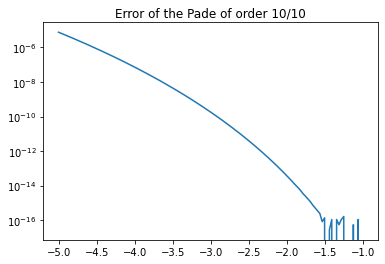

In [27]:
#Computing Pade approximant
import numpy as np
import mpmath
%matplotlib inline
from mpmath import pade, taylor, polyval
import matplotlib.pyplot as plt
x = np.linspace(-5, -1, 128)
a = taylor(mpmath.exp, 0, 20) #Taylor series
k1 = 10
k2 = 10
p, q = pade(a, k1, k2) #Pade approximant
#plt.plot(x, polyval(p[::-1], x)/polyval(q[::-1], x) - np.exp(x))
plt.semilogy(x, polyval(a[::-1], x) - np.exp(x))

_ = plt.title('Error of the Pade of order {0:d}/{1:d}'.format(k1, k2) )

## Scaling & squaring algorithm

The "canonical algorithm" for the computation of the matrix exponential also relies on **scaling** of the matrix $A:$

$$\exp(A) = \exp(A/2^k)^{(2^k)}.$$

The matrix then can have a small norm, thus:

- Scale the matrix as $B := A/2^k$ to make it norm less than $1$.
- Compute exponent of $C = e^B$ by a **Pade approximant**
- Square $e^A \approx C^{(2^k)}$ in $k$ matrix-by-matrix products.

## Large-scale matrix exponentials

- Large-scale matrices obviously do not allow for efficient scaling-and-squaring (need to work with dense matrices), thus we can use **Krylov methods** or (better) Rational Krylov methods.

- The idea of a rational Krylov subspace is motivated by the idea of rational approximation instead of polynomial approximation.

- Krylov methods rely on polynomial approximations

## Rational Krylov subspaces

The simplest (yet efficient) approach is based on the so-called **extended Krylov subspaces:**

$$KE(A, b) = \mathrm{Span}(\ldots, A^{-2} b, A^{-1} b, b, A b, A^2 b, \ldots)$$

At each step you add a vector of the form $A w$ and $A^{-1} w$ to the subspace, and orthogonalize the result (**rational Arnoldi method**).

I.e., we need only linear system solver for one step, but since the matrix $A$ is fixed, we can **factorize it** once

## Rational Krylov methods

Rational Krylov methods are the most efficient for the computation of matrix functions:

- we construct an orthogonal basis in the span,

$$KE(A, b) = \mathrm{Span}(\ldots, A^{-2} b, A^{-1} b, b, A b, A^2 b, \ldots)$$

- compute

$$f(A)b \approx Q f(H) Q^*b,$$

where $H = Q^* A Q.$

It requires one solver and matrix-by-vector product at each step.

## Other matrix functions

Now, let us briefly talk about **other** matrix functions:

- sign
- inverse square root

## Sign function

- Sign function is defined as

$$\mathrm{sign}(x) = \begin{cases} 1, \quad x > 0, \\ -1, \quad x < 0. \end{cases}$$

- Given a matrix $A = U \Lambda U^*$, it effectively puts all the eigenvalues larger than $0$ to $1$, and all eigenvalues smaller than $0$ to $-1$, thus

$$P = \frac{(I + \mathrm{sign}(A))}{2}$$

is a **projector** onto the subspace spanned by all positive eigenvalues. 

- Such projectors can be very useful in **large-scale** eigenvalue computations, when you only need to find a subspace.

## How to compute sign function?

- There is a very simple iteration to compute the sign function, namely

$$X_{k+1} = \frac{1}{2} (X_k + X^{-1}_k), X_0 = \alpha A.$$

- This iteration converges **quadratically** to the sign function.

- You can also get a polynomial iteration, [proposed by R. Byers](http://www.sciencedirect.com/science/article/pii/0024379587902229)

$$X_{k+1} = \frac{1}{2} X_k (3 I - X_k), \quad X_0 = \alpha A.$$

## Inverse square root of the matrix

- The inverse square root of the matrix, $A^{-1/2}$ is also often important.

- For example, the multidimensional Gaussian distribution with covariance matrix $A = A^* > 0$ is given by the 

$$e^{A^{-1} x, x}.$$

- Suppose $x$ is really huge (millions), how we **generate samples**, given a structured matrix $A$?

- The simplest algorithm is to generate a normally distributed vector $y$ with $y_i$ from $N(0, 1)$, and then compute

$$x = A^{-\frac{1}{2}} y.$$

- The vector $x$ will have the desired distribution.

- To compute matrix square root it is very efficient to use **rational Krylov subspaces.**

## Matrix equations

- An equation of the form 

$$F(X) = G, \quad X \in \mathbb{R}^{n \times m}$$ 

is called **matrix equation**.

- A linear matrix equation is when $X$ and $G$ are matrices, and $F$ is a linear operator.

## Two important matrix equations

We will discuss two matrix equations:

- **Sylvester equation** of the form

$$ A X + X B = C,$$

where $A$ and $B$ are given, and its special case, **continious Lyapunov equation**,

$$ A X + XA^{\top} = C,$$

and 

- **discrete Lyapunov equation**

$$A X A^* - X = C. $$

## Application of the Lyapunov equation

- Lyapunov equation is very important for the stability of dynamical systems, and also for model order reduction.

$$\frac{dy}{dt} = Ay, \quad y(0) = y_0,$$

$$y(t) \rightarrow 0$$ for $t \rightarrow \infty$.

- System is stable, iff for any $Q = Q^* > 0$ there exists a unique positive definite solution $P$ of the Lyapunov equation

$$A P + P A^* = Q.$$

- The stability then can be checked without finding eigenvalues.

## Application to model order reduction

Model order reduction of linear time-invariant systems:

$$\frac{dx}{dt} = Ax + Bu, \quad y = C x,$$

where $x$ is **state**, $u$ is control, and $y$ is the observable. We want to approximate it by a smaller-dimensional linear system

$$
   \frac{d\widehat{x}}{dt} = \widehat{A} \widehat{x} + \widehat{B} u, \quad y = \widehat{C} \widehat{x},
$$

in such a way that the output of the reduced system is close to the output of the original (big one).

The optimal $\widehat{A}, \widehat{B}, \widehat{C}$ can be recovered from the solution of the auxiliary Lyaupunov equations.

## Solution of the Sylvester equation

$$ A X + X B = C,$$

- This is a system of linear equations for $X$.

- It can be rewritten as a linear system using the **vec** and **Kronecker product** operations.

- First, we introduce the $\mathrm{vec}$ operation by taking the element of a matrix into a one long vector.

## Kronecker product

A Kronecker product of two matrices $A \in \mathbb{R}^{n_1 \times m_1}, \quad B \in \mathbb{R}^{n_2 \times m_2}$ is a matrix $C$ of size $(n_1 n_2) \times (m_1 m_2)$.

Of the block form

$$A \otimes B = [a_{ij} B].$$

## Main property of the Kronecker product and vec

We have

$$\mathrm{vec}(A X B^{\top}) = (B \otimes A) \mathrm{vec}(X).$$

## Solving Sylvester equation: Bartels-Stewart method

$$(I \otimes A + B^{\top} \otimes I) x = c.$$

Let us compute Schur decomposition of $A$ and $B$:

$$A = Q_A T_A Q^*_A, \quad B^{\top} = Q_B T_B Q^*_B.$$

Then, we have

$$(I \otimes A + B^{\top} \otimes I) = (I \otimes ( Q_A T_A Q^*_A ) + (Q_B T_B Q^*_B \otimes I) = (Q_B \otimes Q_A) ( I \otimes T_A + T_B \otimes I) (Q^* _B \otimes Q^*_A). $$

We have 

$$(Q_B \otimes Q_A)^{-1} = Q^*_B \otimes Q^*_A,$$

thus we only need to solve an auxiliary linear system with the matrix  

$$I \otimes T_A + T_B \otimes I.$$

Note, that if $A$ and $B$ are Hermitian, then $T_A$ and $T_B$ are diagonal, and this matrix is diagonal!

## Solving a final system

We have the system 

$$(I \otimes T_A + T_B \otimes I) z = g,$$

in the matrix form:

$$T_A Z + Z T^{\top}_B = G.$$

Then we just write the equation elementwise and see that the equations are solved successively for $Z_{11}, Z_{21}, \ldots, $.

## Take home message

- Matrix functions: matrix exponential, methods to compute matrix exponential
- Rational Krylov subspace


## Plan for the next class

- Tensors
- Tensor decompositions
- Applications

In [21]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()